# Trappist 1C Transit Spectra

## Tutorials:

   https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/transit_spectroscopy_notebook/Exoplanet_Transmission_Spectra_JWST.ipynb
        
#### Juliet example:        
        
https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/soss-transit-spectroscopy/HAT-P-1b-PART3-data-analysis.ipynb


#### Juliet package
https://juliet.readthedocs.io/en/latest/tutorials/jointfits.html


##### More notebooks:
https://spacetelescope.github.io/jdat_notebooks/

## Import libraries

In [2]:
# General internal libraries:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev
from scipy.ndimage import gaussian_filter1d
from astropy.io import fits

# Juliet (for transit fitting & model evaluation:)
from astropy.table import Table
from sklearn import preprocessing
import numpy as np
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits as pyfits
from astropy.stats.funcs import median_absolute_deviation as MAD
from scipy.ndimage import label

from scipy.ndimage import median_filter
from astropy.utils.data import download_file
# Library for some power-spectral density analysis:
from astropy.timeseries import LombScargle
# Useful library to obtain wavelength map solution from the JWST pipeline:
from jwst import datamodels
# Corner (for posterior distribution plotting):
import corner
# Juliet (for transit fitting & model evaluation:)
import juliet
import ktransit
#Import required libraries
import numpy as np
import batman #package by Laura Kreidberg: http://astro.uchicago.edu/
import emcee #package by Dan Foreman-Mackey: http://dan.iel.fm/emcee
import corner #package by Dan Foreman-Mackey: http://corner.readthedo
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


ERROR:   Could not load MultiNest library "libmultinest.so"
ERROR:   You have to build it first,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: http://johannesbuchner.github.com/PyMultiNest/install.html


ERROR:   Could not load MultiNest library: libmultinest.so
ERROR:   You have to build MultiNest,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: http://johannesbuchner.github.com/PyMultiNest/install.html

problem: libmultinest.so: cannot open shared object file: No such file or directory


## Read whitelight data

In [3]:
#wf= Table.read("jw02420-o001_t001_nirspec_clear-prism-s1600a1-sub512s_whtlt.ecsv", format='ascii.ecsv')

In [4]:
import astropy
efile = "jwst/jw02420whtlt.csv"
import pandas as pd
#pd.set_option("display.precision", 14)
df = pd.read_csv(efile)
wf = df
wf

,MJD,whitelight_flux
0,59771.897668,2.958450
1,59771.897675,2.975147
2,59771.897682,2.487880
3,59771.897689,3.028783
4,59771.897696,2.601572
...,...,...
27454,59771.897634,2.441627
27455,59771.897640,2.880299
27456,59771.897647,2.748113
27457,59771.897654,2.891922


### Normalize Data

In [5]:
data =np.array(wf["whitelight_flux"])
norm = preprocessing.normalize(data.reshape(1, -1))

In [6]:
import numpy as np
from astropy.time import Time
from cysgp4 import PyDateTime

In [7]:
 PyDateTime.from_mjd(59771.8134268345)

<PyDateTime: 2022-07-11 19:31:20.078500 UTC>

### Plot  Raw Data

Text(0.5, 1.0, 'White Light Flux for Trappist1-C JWST Transit')

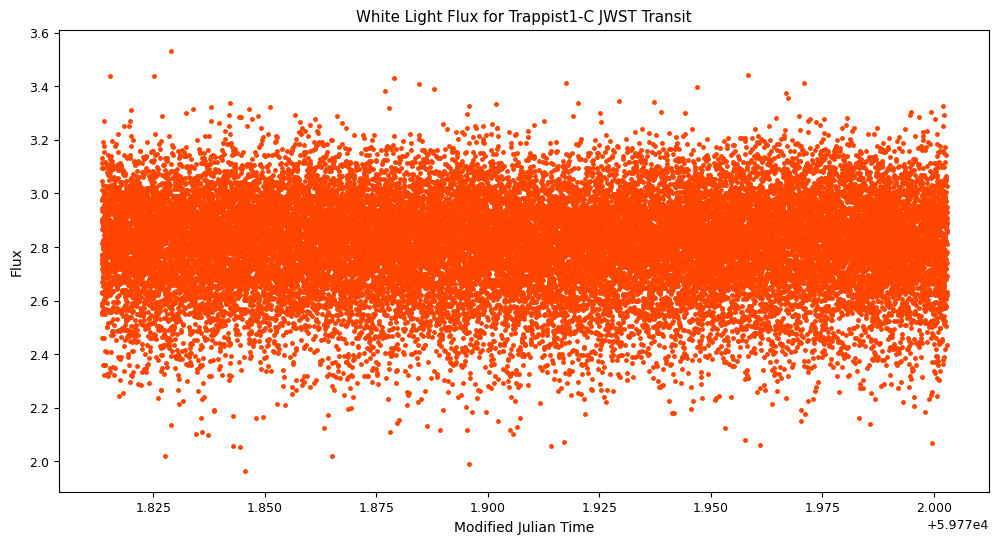

In [8]:
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False,figsize=(12, 6))
ax1.set_ylabel('Flux', fontsize = 10)
ax1.set_xlabel('Modified Julian Time', fontsize = 10)
plt.plot(wf['MJD'],wf["whitelight_flux"], '.', color = 'orangered')
plt.title("White Light Flux for Trappist1-C JWST Transit")

## Bin Transit Times
Round time (MJD) to 3 decimal plcaces and group by mean

In [9]:
r = round(pd.DataFrame(wf['MJD']), 3)
wf["bin"]=r["MJD"]
na=np.array(wf)
df = pd.DataFrame(na)
df.columns = ["MJD","whitelight_flux", "bin"]
# Use GroupBy() to compute the sum
df2 = df.groupby('bin').mean()
df2.pop("MJD")
df2["MJD"] = df2.index
df2.reset_index()

,bin,whitelight_flux,MJD
0,59771.813,2.864321,59771.813
1,59771.814,2.813163,59771.814
2,59771.815,2.820870,59771.815
3,59771.816,2.822295,59771.816
4,59771.817,2.811697,59771.817
...,...,...,...
186,59771.999,2.809815,59771.999
187,59772.000,2.780411,59772.000
188,59772.001,2.783923,59772.001
189,59772.002,2.802067,59772.002


## Define planet and star parameters

In [10]:
t1 = np.array(df2["MJD"])
transit_duraton = .038
#Full transit
per =2.4218233
#Median transit point from data
t0=np.median(np.array(df2["MJD"]))
#Phase
phase=(t1-t0)/(per)
#Radius Star
Rstar=0.117 
# semi-major axis (input a/Rstar so units of stellar radii)
a_Rs=44.94
#inclination
inc=89.65 *(2*np.pi/360) 
# Radius planet
p =p =(1.121 *3958.8) *(np.pi/180.0)
#Radius star
s=(432690 *0.117)*(np.pi/180.0)
#Planet to star radius ratio
rp = p/s
# Derived transit duraion
b0 =a_Rs * np.sqrt((np.sin(phase * 2* np.pi)) ** 2 + (np.cos(inc) * np.cos(phase * 2 * np.pi)) ** 2)
intransit = np.array((b0-rp < 1.0E0)).nonzero() 
outtransit =  np.array((b0-rp > 1.0E0)).nonzero()

#Transit duration = 0.0388 days
#Mid transit time from median MJD
tend =df2["MJD"].max()-0.07599999999752617
tstart=df2["MJD"].min()+0.07599999999752617

## Data Derived
tend1 =df2["MJD"].max()-0.06899999999752617
tstart1=df2["MJD"].min()+(0.07599999999752617+(0.07599999999752617-0.06899999999752617))

tend2 =df2.iloc[intransit]["MJD"].max()
tstart2=df2.iloc[intransit]["MJD"].min()

### Plot different transit times

In [11]:
df2=df2.reset_index()
data =np.array(df2["whitelight_flux"])
norm = preprocessing.normalize(data.reshape(1, -1))
data=pd.DataFrame(data)
data['time']=df2[['MJD']]
data["whitelight_flux"]=data[0]
data

,0,time,whitelight_flux
0,2.864321,59771.813,2.864321
1,2.813163,59771.814,2.813163
2,2.820870,59771.815,2.820870
3,2.822295,59771.816,2.822295
4,2.811697,59771.817,2.811697
...,...,...,...
186,2.809815,59771.999,2.809815
187,2.780411,59772.000,2.780411
188,2.783923,59772.001,2.783923
189,2.802067,59772.002,2.802067


In [12]:
t = np.linspace(-0.025, 0.025, 191) #times at which to calculate light curve

### Plot Binned data -- Relative Flux

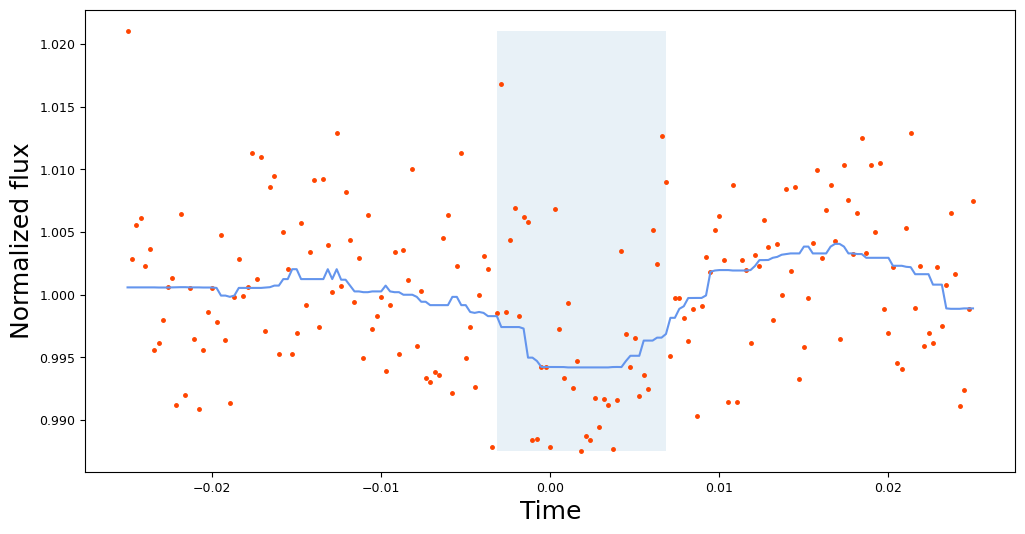

In [13]:
ff_df=df2["whitelight_flux"] / np.median(df2["whitelight_flux"])
smoothed_petit_transit = median_filter(df2["whitelight_flux"] / np.median(df2["whitelight_flux"]), 35)
sp = pd.DataFrame(smoothed_petit_transit)
sp.index = df2.index
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False,figsize=(12, 6))
ax1.plot(t,ff_df, '.', color = 'orangered')
ax1.plot(t,sp, '-', color = 'cornflowerblue')
ax1.set_ylabel('Normalized flux', fontsize = 18)
ax1.set_xlabel('Time', fontsize = 18)
ax1.fill_between(t, min(ff_df), max(ff_df), where=(t <= t[df2["MJD"]>=tend1].min()) & (t >= t[df2["MJD"]==tstart1]), alpha=0.1)

## BATMAN LIMB DARKENING

## Parameters

In [14]:
#Initialize Parameters
params = batman.TransitParams() #object to store transit parameters
params.t0 = 0.002 #time of inferior conjunction
params.per = 2.4218233 #orbital period
p=(1.121 *3958.8) *(np.pi/180.0)
s=(432690 *0.117)*(np.pi/180.0)
params.rp =0.094# p/s #planet radius (in units of stellar radii)
params.a = 64.9460888581529  #semi-major axis (in units of stellar radii)
params.inc = 89.65 #*(2*np.pi/360)  #orbital inclination (in degrees
params.ecc = 0.00622   #eccentricity
params.w =0.015712  #  *(2*np.pi/360)   #longitude of periastron (in degrees)

## Quadratic

NameError: name 'fll' is not defined

<Figure size 1200x1000 with 0 Axes>

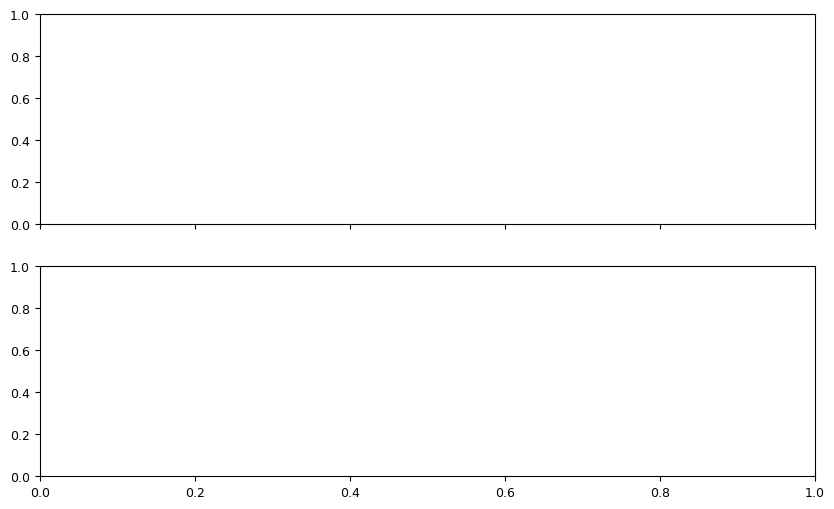

In [15]:
params.limb_dark ="quadratic"#" #limb darkening model ->"uniform", "linear", "quadratic", "nonlinear", etc.
params.u = [.95, 0.35]#, 0.1, -0.1] #limb darkening coefficients
t = np.linspace(-0.025, 0.025, 191) #times at which to calculate light curve
qm = batman.TransitModel(params, t) #initializes model
qfl = qm.light_curve(params) 
fig = plt.figure(figsize=(12, 10))
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False,figsize=(10, 6))
#ax.plot(time, y, 'x', label='sampled data')
ax1.scatter(t,fll,s=2,color='k',label='obs data')
ax1.plot(t,qfl,color='r',label='Quadratic model fit')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Norm Flux')
ax1.fill_between(t, min(fll), max(fll), where=(t <= t[df2["MJD"]>=tend].min()) & (t >= t[df2["MJD"]==tstart]), alpha=0.05)
ax1.fill_between(t, min(fll), max(fll), where=(t <= t[df2["MJD"]>=tend1].min()) & (t >= t[df2["MJD"]==tstart1]), alpha=0.1, color = 'red')
ax2.scatter(t,fll - qfl,s=2,color='k',label='residuals')
plt.legend(loc=0);

## Nonlinear

In [ ]:
params.limb_dark = "nonlinear" #limb darkening model ->"uniform", "linear", "quadratic", "nonlinear", etc.
params.u = [.59, 0.0075,0.75, -0.0055]# darkening coefficients,
m = batman.TransitModel(params, t) #initializes model
fN = m.light_curve(params) 
fig = plt.figure(figsize=(12, 10))
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False,figsize=(10, 6))
#ax.plot(time, y, 'x', label='sampled data')
ax1.scatter(t,fll,s=2,color='k',label='obs data')
ax1.plot(t,fN,color='r',label='nonlinear model fit')
ax1.legend()
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Norm Flux')
ax1.fill_between(t, min(fll), max(fll), where=(t <= t[df2["MJD"]>=tend].min()) & (t >= t[df2["MJD"]==tstart]), alpha=0.05)
ax1.fill_between(t, min(fll), max(fll), where=(t <= t[df2["MJD"]>=tend1].min()) & (t >= t[df2["MJD"]==tstart1]), alpha=0.1, color = 'red')
ax1.fill_between(t,min(fll), max(fll), where=(t <= t[df2["MJD"]>=tend2].min()) & (t >= t[df2["MJD"]==tstart2]), alpha=0.1, color = 'green')
ax2.scatter(t,fll - fN, s=2, color='k',label='residuals')
plt.legend(loc=0)

## LINEAR

In [ ]:
params.limb_dark = "linear" #limb darkening model ->"uniform", "linear", "quadratic", "nonlinear", etc.
params.u = [0.9856] #limb darkening coefficients
m = batman.TransitModel(params, t) #initializes model
flin = m.light_curve(params) 
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False,figsize=(12, 10))
#ax.plot(time, y, 'x', label='sampled data')
ax1.scatter(t,fll,s=2,color='k',label='obs data')
ax1.plot(t,flin,color='r',label='linear model fit')
ax1.legend()
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Norm Flux')
ax1.fill_between(t, min(fll), max(fll), where=(t <= t[df2["MJD"]>=tend].min()) & (t >= t[df2["MJD"]==tstart]), alpha=0.05)
ax1.fill_between(t, min(fll), max(fll), where=(t <= t[df2["MJD"]>=tend1].min()) & (t >= t[df2["MJD"]==tstart1]), alpha=0.1, color = 'red')
ax1.fill_between(t,min(fll), max(fll), where=(t <= t[df2["MJD"]>=tend2].min()) & (t >= t[df2["MJD"]==tstart2]), alpha=0.1, color = 'green')
ax2.scatter(t,fll - flin, s=2, color='k',label='residuals')
plt.legend(loc=0)

## Plot Limb Darkening

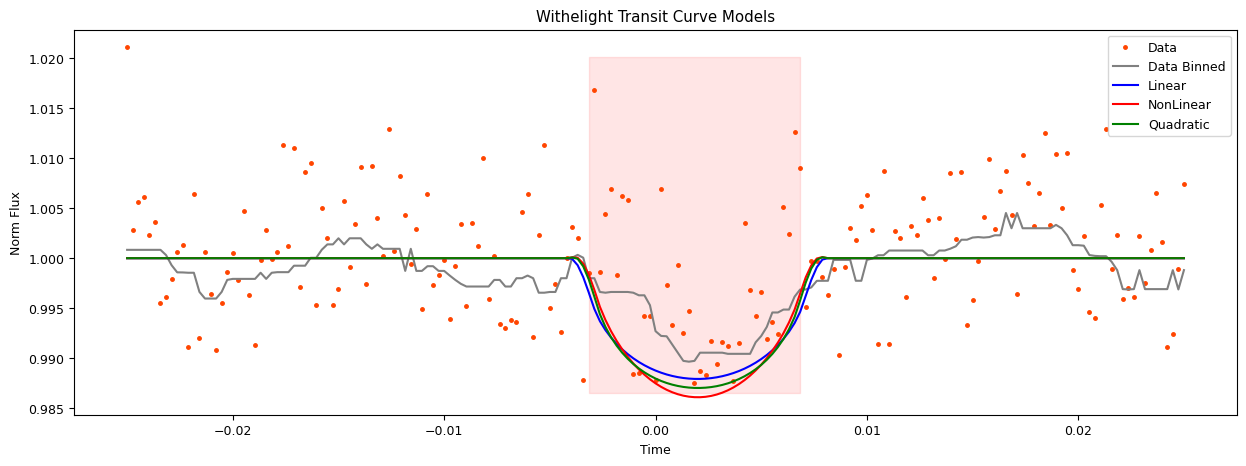

In [35]:

t = np.linspace(-0.025, 0.025, 191)
f=df2["whitelight_flux"] / np.median(df2["whitelight_flux"])
s= median_filter(df2["whitelight_flux"] / np.median(df2["whitelight_flux"]), 20)-.002
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False,figsize=(15, 5))
ax1.plot(t, df2["whitelight_flux"] / np.median(df2["whitelight_flux"]),'.', label='Data',  color = 'orangered')
ax1.plot(t, s,label='Data Binned',  color = 'gray')
ax1.plot(t, flin,label='Linear', color='blue') #green
ax1.plot(t, fN,label='NonLinear', color ='red')
ax1.plot(t, qfl,label='Quadratic', color = 'green')
#ax1.plot(t,true_regression_line+1,color='yellow',label='LC')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Norm Flux')
plt.title("Withelight Transit Curve Models")
#ax1.fill_between(t, min(f)-(min(f)*.002), max(f)-(min(f)*.002), where=(t <= t[df2["MJD"]>=tend].min()) & (t >= t[df2["MJD"]==tstart]), alpha=0.05)
ax1.fill_between(t, min(f)-(min(f)*.001), max(f)-(min(f)*.001), where=(t <= t[df2["MJD"]>=tend1].min()) & (t >= t[df2["MJD"]==tstart1]), alpha=0.1, color = 'red')
#ax1.fill_between(t,min(f)-(min(f)*.0015), max(f), where=(t <= t[df2["MJD"]>=tend2].min()) & (t >= t[df2["MJD"]==tstart2]), alpha=0.1, color = 'green')

## Semi major axis calculations

 AU, UA	214.9394693836 Sun's radius
R_star_km=(432690 *0.117)#*(np.pi/180.0)
R_star
AU in sun = 0.00465047
semi-major axis = 0.01521 AU in km = 2275383.613
R_star=50624.73km
R star in au = 0.00033840541823 AU
R star in radii = 883.568221433149 -- (50624.73 )*(np.pi/180.0)
semi major axis in radii = 39712.93579277445 #(2275383.613*(np.pi/180.0))
semi divided by start radii = 44.94608885815292 # (2275383.613*(np.pi/180.0))/883.568221433149 

# FITS Data
Take Stage3 file form MAST and combine the wavelenghts for each timetpoint into 1 table

In [ ]:
hdul = fits.open('jwst/jw02420-o001_t001_nirspec_clear-prism-s1600a1-sub512s_x1dints.fits')
Table.read(hdul[27000])

In [ ]:
hdul = fits.open('jwst/jw02420-o001_t001_nirspec_clear-prism-s1600a1-sub512s_x1dints.fits')
pd.set_option("display.precision", 18)
df = pd.DataFrame(columns = ['w', 'FLUX',"FLUX_ERROR"])
time = pd.DataFrame(np.array(Table.read(hdul[1])["int_mid_MJD_UTC"]))
for i in range(2,27461):
    t =wf["MJD"][i-2]
    d = Table.read(hdul[i])
    #f =np.sum(np.array(d['FLUX']>0))#.mean() #- d['FLUX'].min()
    d["w"]=d["WAVELENGTH"]
    d = d[d['FLUX']>0,]
    d=d[["w", "FLUX", "FLUX_ERROR"]]
    d['time'] = t
    d=pd.DataFrame(np.array(d))
    df =pd.concat([df,d], axis = 0,ignore_index=True)
np.save('fits_data', np.asarray(df), allow_pickle=True, fix_imports=True)

## Load Saved Fits Numpy Data

In [ ]:
df=np.load('jwst/fits_data.npy')
df = pd.DataFrame(df,columns=["w", "FLUX", "FLUX_ERROR", "time", "w3", "bin", "wave"])
data=df['FLUX']
data=(data - np.min(data)) / (np.max(data) - np.min(data))
data = pd.DataFrame(data)
df['Norm_FLUX']=data#df["FLUX"] / np.median(df["FLUX"])
datae=df['FLUX_ERROR']
datae=(datae - np.min(datae)) / (np.max(datae) - np.min(datae))
datae = pd.DataFrame(datae)
df['Norm_FLUX_ERR']=datae#df["FLUX"] / np.median(df["FLUX"])
df[["w", "FLUX", "FLUX_ERROR", "time"]].describe()

## Wavelength dependent light curve

In [ ]:
end = tend1
start = tstart1
df['wave']=df['w']
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False,figsize=(12, 6))
df["Tr"]= round(df["time"], 3)
df["w3"]= round(df["wave"], 15)
df_1=df[df['time']>=start]
df_1=df_1[df_1['time']<=end]
df_gr= df_1.groupby(by=["w3"]).sum()
df_gr=df_gr.reset_index()
df_gr=df_gr[df_gr['FLUX']>30]
#ax1.plot(df_gr["Tr"], df_gr["FLUX"])
#smoothed_petit_transit = median_filter(df_gr["FLUX"], 5)
smoothed_petit_transit = median_filter(df_gr["FLUX"] / np.median(df_gr["FLUX"]),5)
#plt.plot(df_gr["w3"], df_gr["FLUX"], color = 'red') 
plt.plot(df_gr["w3"],smoothed_petit_transit)
#ax1.plot(df_gr["w"],smoothed_petit_transit, '-', color = 'cornflowerblue')

## Plot Wavelenght Binning

Create function

In [ ]:
def plot_w(df, w, w1):
    dfw=df[df['w']<=w]
    dfw=dfw[dfw['w']>w1]
    data = dfw["FLUX"]
    data=(data - np.min(data)) / (np.max(data) - np.min(data))
    data = pd.DataFrame(data)
    dfw['Norm_FLUX']=data#df["FLUX"] / np.median(df["FLUX"])
    #df['smooth']= median_filter(df["Norm_FLUX"] / np.median(df["Norm_FLUX"]),20)
    df_gr= dfw.groupby(by=["w"]).sum()
    df_gr=df_gr.reset_index()
    #df_gr=df_gr[df_gr['Norm_FLUX']>.05]
    fig, ax = plt.subplots(2, 3, sharex=True, sharey=False,figsize=(12, 6))
    s3= median_filter(df_gr["Norm_FLUX"],30)
    s1= median_filter(df_gr["Norm_FLUX"] ,5)
    s2= median_filter(df_gr["Norm_FLUX"] ,20)
    s4= median_filter(df_gr["Norm_FLUX"] ,40)
    s5= median_filter(df_gr["Norm_FLUX"] ,50)
    ax[0,0].scatter(df_gr["w"],df_gr['Norm_FLUX'], s=3, color = 'red', label='Norm Flux', alpha =.5)
    ax[0,0].legend()
    ax[0,1].plot(df_gr["w"],s1, label='S=10', alpha =.5)
    ax[0,1].legend()
    ax[0,2].plot(df_gr["w"],s2, label='S=20', alpha =.5)
    ax[0,2].legend()
    ax[1,0].plot(df_gr["w"],s3, label='S=30', alpha =.5)
    ax[1,0].legend()
    ax[1,1].plot(df_gr["w"],s4, label='S=40', alpha =.5)
    ax[1,1].legend()
    ax[1,2].plot(df_gr["w"],s5, label='S=50', alpha =.5)
    ax[1,2].legend()

In [ ]:
plot_w(df, w=5, w1=0)

In [ ]:
plot_w(df, w=5, w1=3)

In [ ]:
plot_w(df, w=3, w1=0)

## FITS Time Binning

In [ ]:
df_all = df.groupby(by=["time"]).median()
df_all = df_all.reset_index()
df_all['bin']=round(df_all['time'],3)
df2a = df_all.groupby('bin').mean()
df2a=df2a.reset_index()
norm = preprocessing.normalize(np.array(df2a["FLUX"]).reshape(1, -1))
data = df2a["FLUX"]
data=(data - np.min(data)) / (np.max(data) - np.min(data))
data = pd.DataFrame(data)
df2a['Norm_FLUX']=data
datae = df2a["FLUX_ERROR"]
datae=(datae - np.min(datae)) / (np.max(datae) - np.min(datae))
datae = pd.DataFrame(datae)
df2a['Norm_FLUX_ERR']=datae
ds = df2a['bin']-59771
data["bin"]= ds
df2a.reset_index()
np.save('fits_data_191', np.asarray(df2a), allow_pickle=True, fix_imports=True)                                                                  

In [ ]:
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False,figsize=(12, 6))
ax1.set_ylabel('Flux', fontsize = 10)
ax1.set_xlabel('Time', fontsize = 10)
plt.plot(df2a['time'],df2a["FLUX"], '.', color = 'orangered')

plt.title("Wavelength Flux for Trappist1-C JWST Transit")

## Plot FITS Light Curve

In [ ]:
start = tstart1
end = tend1

fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False,figsize=(12, 6))
ff_df=df2a["Norm_FLUX"] #df2a["FLUX"] / np.median(df2a["FLUX"])
er = df2a["FLUX_ERROR"] 
t = np.linspace(-0.025, 0.025, len(er)) #times at which to calculate light curve
smoothed_petit_transit = (median_filter(ff_df/ np.median(ff_df)-.5, 25))
ax1.plot(t, ff_df, '.',color = 'orangered')
ax1.plot(t, er+ff_df,  '.',color = 'green')
ax1.plot(t, smoothed_petit_transit, '-', color = 'cornflowerblue')
ax1.fill_between(t, min(ff_df), max(ff_df), where=(t <= t[df2a["time"]>=end].min()) & (t >= t[df2a["time"]>=start].min()), alpha=0.1)

In [ ]:
start = tstart1
end = tend1

fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False,figsize=(12, 6))
ff_df=df2a["Norm_FLUX"] #df2a["FLUX"] / np.median(df2a["FLUX"])
er = df2a["FLUX_ERROR"] 
t = np.linspace(-0.025, 0.025, len(er)) #times at which to calculate light curve
smoothed_petit_transit = (median_filter(ff_df/ np.median(ff_df)-.5, 25))
ax1.plot(t, ff_df,color = 'orangered')
#ax1.plot(t, er+ff_df,,color = 'green')
ax1.plot(t, smoothed_petit_transit, '-', color = 'cornflowerblue')
ax1.fill_between(t, min(ff_df), max(ff_df), where=(t <= t[df2a["time"]>=end].min()) & (t >= t[df2a["time"]>=start].min()), alpha=0.1)

## Plot Light Curve for Wavelength Bibs

In [ ]:
lightbins = np.linspace(.6, 5, 17)
beg = lightbins[:-1]
en = lightbins[1:]
lightbins
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 22))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Wavelenght Light Curves", fontsize=18, y=0.95)

# loop through tbinsand axes
for b, e, ax in zip(beg, en, axs.ravel()):
    df1= df[df['w']>=b]
    df1= df1[df1['w']<e]
    df_all = df1.groupby(by=["time"]).sum()
    df_all = df_all.reset_index()
    df_all['bin']=round(df_all['time'],3)
    df2a = df_all.groupby('bin').mean()
    df2a=df2a.reset_index()
    norm = preprocessing.normalize(np.array(df2a["FLUX"]).reshape(1, -1))
    data = df2a["FLUX"]
    data=(data - np.min(data)) / (np.max(data) - np.min(data))
    data = pd.DataFrame(data)
    ds = df2a['bin']-59771
    data["bin"]= ds
    df2a=df2a.reset_index()
    df2a=df2a[(df2a["FLUX"] / np.median(df2a["FLUX"]))>.89]
    end = tend2
    start = tstart1
    df2a=df2a[15:]
    df2a=df2a.reset_index()
    t = np.linspace(-0.025, 0.025, df2a.shape[0]) #times at which to calculate light curve
    ff_df=df2a["FLUX"] / np.median(df2a["FLUX"])
    smoothed_petit_transit = (median_filter(ff_df/ np.median(ff_df), 15))
    ax.plot(t, ff_df, '.', color = 'orangered')
    ax.plot(t, smoothed_petit_transit, '-', color = 'cornflowerblue')
    ax.fill_between(t, min(ff_df), max(ff_df), where=(t <= t[df2a["time"]>=tend1].min()) & (t >= t[df2a["time"]>=tstart1].min()), alpha=0.1)
    # chart formatting
    ax.set_title('Wavelength bin, {:.2f} - {:.2f}'.format(b,e ))
    ax.set_xlabel("")

plt.show()

## Wavelengt Light Curves

In [ ]:
import juliet

def plot_w_curves(lightbins, colors):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
    bb=[0,6,12]
    ee = [7,13,19]
    for ax, b1,e1, clr in zip(axs.ravel(), bb, ee, colors):
       # ax.set_figure(figsize=(5, 10))
        beg = lightbins[b1:e1-1]
        en = lightbins[b1+1:e1]
        delta = 0.05
        counter = 0
        colr = plt.get_cmap(clr)
        color = [colr(k) for k in np.linspace(0.4, 1.0, len(beg ))]
        for b, e, c in zip(beg, en, color):
            df1= df[df['w']>=b]
            df1= df1[df1['w']<e]
            df_all = df1.groupby(by=["time"]).mean()
            df_all = df_all.reset_index()
            df_all['bin']=round(df_all['time'],4)
            df2a = df_all.groupby('bin').mean()
            df2a=df2a.reset_index()
            norm = preprocessing.normalize(np.array(df2a["FLUX"]).reshape(1, -1))
            data = df2a["FLUX"]
            data=(data - np.min(data)) / (np.max(data) - np.min(data))
            data = pd.DataFrame(data)
            ds = df2a['bin']-59771
            data["bin"]= ds
            df2a=df2a.reset_index()
            end = tend2
            start = tstart1
           # df2a=df2a[25:]
            df2a=df2a.reset_index()
            t = np.linspace(-0.025, 0.025, df2a.shape[0]) #times at which to calculate light curve
            ff_df=df2a["FLUX"] / np.median(df2a["FLUX"])
            ff_dfe=df2a["FLUX_ERROR"] / np.median(df2a["FLUX_ERROR"])
            xbin, ybin, ybinerr = juliet.utils.bin_data(t,  ff_df, 50)
            ax.errorbar(t,  ff_df + counter * delta,  fmt = '.', \
                         alpha = 0.05, zorder = 1, elinewidth = .2, color = c, label='Wavelength bin, {:.2f} - {:.2f}'.format(b,e ))
           # ax.legend(fontsize = 6)
            ax.text(x=-.025,y=(ff_df.median() +  counter * delta+.02),s='Bin {:.2f} - {:.2f}'.format(b,e ),fontsize =8)

            ax.errorbar(xbin, ybin  + counter * delta, ybinerr, fmt = 'o', ms = 5, mfc = 'white', mec = 'black', ecolor = 'black',
                         elinewidth = .5, zorder = 4,alpha = 0.5)

            counter+=1
        ax.set_ylim(0.97, 1.3)
        ax.set_xlabel('Time from mid-transit', fontsize = 9)
        ax.set_ylabel('Relative flux + offset', fontsize = 9)
        ax.set_title("Wavelenght Light Curves {:.2f} - {:.2f}".format(lightbins[b1],e ))
colors=["Reds", "Blues", "Greens"]
lightbins = np.linspace(.6, 5, 19)
plot_w_curves(lightbins, colors)

## Whitelight curve fitting with Juliet

In [38]:
## Data Derived
tend1 =df2["MJD"].max()-0.06899999999752617
tstart1=df2["MJD"].min()+(0.07599999999752617+(0.07599999999752617-0.06899999999752617))

Parameter name	Description\
P_p1	The planetary period of the planet under study (days).\
t0_p1	The time-of-transit center of the planet under study (days).\
p_p1	Planet-to-star radius ratio (Rp/Rs).\
b_p1	Impact parameter of the orbit.\
a_p1	Scaled semi-major axis of the orbit (a/R*).\
ecc_p1	Eccentricity of the orbit.\
omega_p1	Argument of periastron passage of the orbit (in degrees).\
K_p1	RV semi-amplitude of the orbit of the planet (same units as RV data).\

#Initialize Parameters
params = batman.TransitParams() #object to store transit parameters
params.t0 = 0.002 #time of inferior conjunction
params.per = 2.4218233 #orbital period
p =p =(1.121 *3958.8) *(np.pi/180.0)
s=(432690 *0.117)*(np.pi/180.0)
params.rp =0.094# p/s #planet radius (in units of stellar radii)
params.a = 64.9460888581529  #semi-major axis (in units of stellar radii)
params.inc = 89.65 #*(2*np.pi/360)  #orbital inclination (in degrees
params.ecc = 0.00622   #eccentricity
params.w =0.015712  #  *(2*np.pi/360)   #longitude of periastron (in degrees)

In [39]:
+-------------+----------------+----------------+-----------------------+----------+
| Parameter   | Distribution   |        Input A | Input B               | Filter   |
|-------------+----------------+----------------+-----------------------+----------|
| P           | gaussian       |    2.42194     | 0.002421937           |          |
| t0          | gaussian       |    2.45728e+06 | 0.007                 |          |
| a           | gaussian       |    0.0158      | 0.0031600000000000005 |          |
| inc         | gaussian       |   89.778       | 17.9556               |          |
| w           | gaussian       |  282.45        | 77.55000000000001     |          |
| ecc         | gaussian       |    0.00654     | 0.00327               |          |
| rp          | uniform        |    0.0419614   | 0.12588428924750003   | 0        |

SyntaxError: invalid syntax (574190076.py, line 1)

## JULIET Whitelight

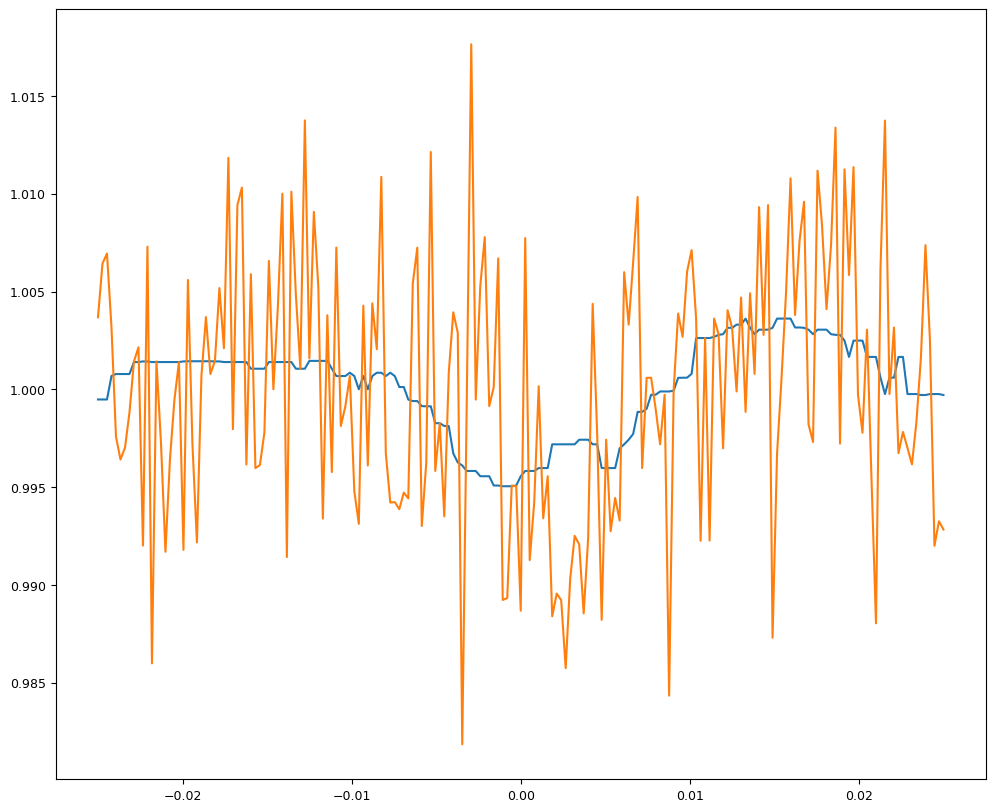

In [40]:
import pandas as pd
import astropy
efile = "jwst/jw02420whtlt.csv"
import pandas as pd
#pd.set_option("display.precision", 14)
wf = pd.read_csv(efile)

df=np.load('jwst/fits_data.npy')
df = pd.DataFrame(df,columns=["w", "FLUX", "FLUX_ERROR", "time", "w3", "bin", "wave"])
wf['err'] =df['FLUX_ERROR']
wf['t'] = round(wf['MJD'], 3)
d = wf.groupby(['t']).sum()
d=d.reset_index()
d['FLUX']= d['whitelight_flux']/np.median(d['whitelight_flux'])
d['FLUX_err']= d['err']/np.median(d['err'])
d=d[d['FLUX']>.9]
t = np.linspace(-0.025, 0.025, d.shape[0]) 
ax1.plot(t, d['FLUX'])
fig, ax1= plt.subplots(1, 1, sharex=True, sharey=False,figsize=(12, 10))
smoothed_petit_transit = (median_filter(d['FLUX']/np.median(d['FLUX']), 50))
ax1.plot(t, smoothed_petit_transit)
ax1.plot(t, d['FLUX']/np.median(d['FLUX']))
times, fluxes, fluxes_error, norm_times = {}, {}, {}, {}
times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = [np.asarray(d['t']),np.asarray(d['FLUX']),
                                              np.asarray((d['err'] - np.min(d['err']))/ (np.max(d['err']) - np.min(d['err']))*.02)]

### Define Parametres

In [41]:

#P_p1 - orbital period
#t0_p1 Time of transit center
params = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_SOSS', 'q2_SOSS', 'ecc_p1', 'omega_p1',
          'rho', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed', 'normal', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'fixed',
         'loguniform', 'fixed', 'normal', 'loguniform']

hyperps = [2.4218233, [59771.899, 0.1689], [0.0015,10], [0.0015,10], [0., 1000.], [0., 1000.], 0.0061 , .11,\
                   [0.1, 1000.], 1.0, [0.,1000], [0.1, 1000.]]

priors = juliet.generate_priors(params, dists, hyperps)


ds= juliet.load(priors=priors, t_lc=times, y_lc=fluxes,
                                        yerr_lc=fluxes_error, ld_laws='squareroot',
                                        out_folder='_juliet_results_w2')


### Run Juliet

Detected dynamic_dynesty sampler output files --- extracting from _juliet_results_w2/_dynesty_DNS_posteriors.pkl


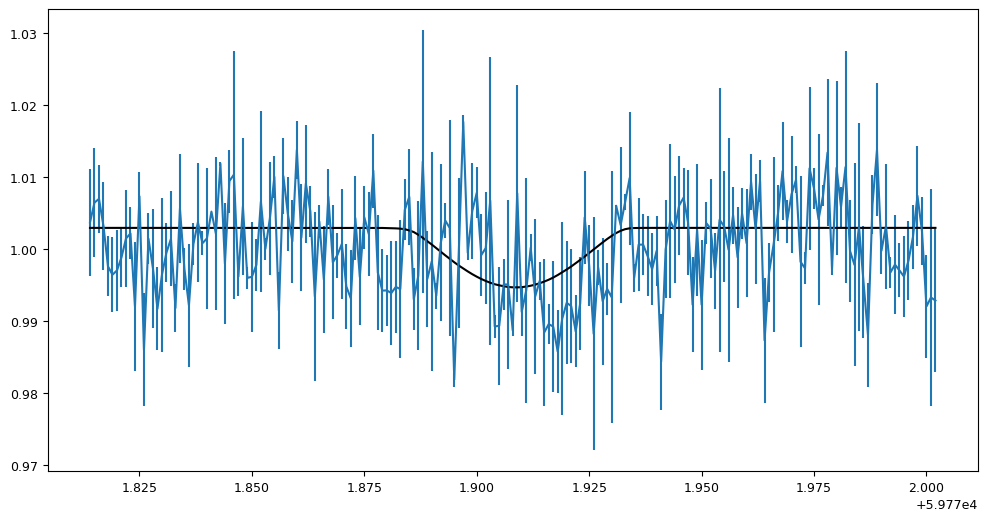

In [42]:
res= ds.fit(use_dynesty=True, dynamic=True, dynesty_nthreads=10)
mod= res.lc.evaluate('SOSS')
fig, ax1= plt.subplots(1, 1, sharex=True, sharey=False,figsize=(12, 6))
plt.errorbar(d['t'], d['FLUX'] ,
           yerr=(d['err'] - np.min(d['err']))/ (np.max(d['err']) - np.min(d['err']))*.02,
             label='Data')
plt.plot(d['t'], mod, color='black', label='Model')

### Plot Juliet Light Curve

Text(0.5, 0, 'Time from mid-transit (hours)')

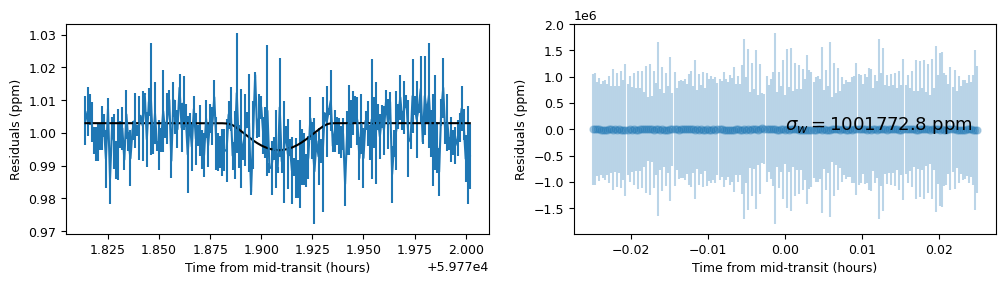

In [52]:
sigma_w = np.median(res.posteriors['posterior_samples']['sigma_w_SOSS'])

# Extract estimated time-of-transit center:
t0 = np.median(res.posteriors['posterior_samples']['t0_p1'])
#plt.figure(figsize=(15, 5)) 
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
# Normalize times to plot by this:
plt.errorbar(d['t'], d['FLUX'] ,
           yerr=(d['err'] - np.min(d['err']))/ (np.max(d['err']) - np.min(d['err']))*.02,
             label='Data')
# Plot best-fit model on top:
mod= res.lc.evaluate('SOSS')
plt.plot(d['t'], mod, color='black', label='Model')
#plt.xlim(np.min(tnorm), np.max(tnorm))
plt.ylabel('Relative flux')
plt.ylabel('Residuals (ppm)')
plt.xlabel('Time from mid-transit (hours)')
# Residuals:
plt.subplot(2,2,2)
resid =  d['FLUX']- mod

plt.errorbar(t, resid*1e6,
             yerr=np.sqrt(d['FLUX_err']**2 + (sigma_w*1e-6)**2)*1e6,
             fmt='o', alpha=0.3)

#plt.xlim(np.min(tnorm), np.max(tnorm))
#plt.ylim(-350, 350)
average_total_errorbar = np.median(np.sqrt(d['FLUX_err']**2 + (sigma_w * 1e-6)**2) * 1e6)
plt.text(0, 0, r'$\sigma_w = {0:.1f}$ ppm'.format(average_total_errorbar), fontsize=13)
plt.ylabel('Residuals (ppm)')
plt.xlabel('Time from mid-transit (hours)')

### Corner Plot -- Parameters

In [ ]:
names = [r'$t_0 - Med[t_0]$ (s)','$R_p/R_s$', '$b = a \cos i$', r'$\rho_*$', r'$u_1$', r'$u_2$']

# Retrieve posterior distributions of parameters for Order 1:
Theta1 = np.zeros([len(res.posteriors['posterior_samples']['t0_p1']), 6])
Theta1[:,0] = res.posteriors['posterior_samples']['t0_p1']

# Convert r1 and r2 sampling scheme to rp/rs and b:
b_1, rprs_1 = juliet.utils.reverse_bp(res.posteriors['posterior_samples']['r1_p1'],
                                      res.posteriors['posterior_samples']['r2_p1'], 0., 1)


Theta1[:,1], Theta1[:,2] = rprs_1, b_1

# Extract stellar density:
Theta1[:,3] = res.posteriors['posterior_samples']['rho']

# Convert q1 and q2 sampling to u1 and u2:
u1_1, u2_1 = juliet.utils.reverse_ld_coeffs('squareroot',
                                            res.posteriors['posterior_samples']['q1_SOSS'],
                                            res.posteriors['posterior_samples']['q2_SOSS'])

Theta1[:,4], Theta1[:,5] = u1_1, u2_1
figure = corner.corner(Theta1, labels=names, color='orangered')
plt.show()

## Residuals

In [ ]:
plt.figure(figsize=(15, 5))

bin_sizes = np.arange(10, 1000, 10)

plt.subplot(1,2,1)
plt.title('Residuals as a function of bin-size')

rms = np.zeros(len(bin_sizes))
for j in range(len(bin_sizes)):
    bin_size = bin_sizes[j]
    binned_times, binned_residuals, binned_errors = juliet.utils.bin_data(d['t'],
                                                                          resid,
                                                                          bin_size)
    rms[j] = np.sqrt(np.var(binned_residuals)) * 1e6

plt.plot(bin_sizes, rms, label='White-light lightcurve')
plt.plot(bin_sizes, (np.sqrt(bin_sizes[0]) * rms[0]) / np.sqrt(bin_sizes), label='Expected ($1/\sqrt{N}$)')
plt.xscale('log')
plt.ylabel('RMS (ppm)')
plt.xlabel('Bin size')

plt.legend()

## Residuals Power Spectrum

In [ ]:
plt.figure(figsize=(15, 5)) 

# Define frequencies in hours. From more or less the duration of the observation (~1 over 10 hours) to the 
# time-sampling (~1 over 1 minute, so over 1/60 hours)
frequency = np.linspace(1. / 10., 1. / (1. / 60.), 1000)

plt.subplot(1,2,1)
plt.title(' Residuals Power Spectral Density (PSD)')

ls = LombScargle((d['t'] - d['t'][1]) * 24, resid)
psd = ls.power(frequency)
max_power = np.max(psd)
max_freq = frequency[np.where(max_power == psd)[0]][0]
fap = ls.false_alarm_probability(max_power) 
print('Maximum power: {0:.4f}, frequency: {1:.2f}, FAP: {2:.2f}%'.format(max_power, max_freq, fap * 100))

plt.plot(frequency,psd)
plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency (1/hr)')
plt.xlim([1. / 10.,60.])

## Wavelenght-dependent light curves

In [ ]:
# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 22))
# plt.subplots_adjust(hspace=0.5)
t0_median =59771.90876479218
b_median =1.3808315614272653
rho_median = 895.5513846214745

lightbins = np.linspace(.6, 5, 19)
beg = lightbins[:-1]
en = lightbins[1:]

results = {} 
models = {} 
residuals = {} 
sigma_ws={}
depthsbin = {}
errors ={}

df=np.load('fits_data.npy')
df = pd.DataFrame(df,columns=["w", "FLUX", "FLUX_ERROR", "time", "w3", "bin", "wave"])
ww=df['w'].unique()
# loop through tbinsand axes
for b in ww:
    df1= df[df['w']==b]
  #  df1= df1[df1['w']<e]
    df_all = df1.groupby(by=["time"]).sum()
    df_all = df_all.reset_index()
    df_all['bin']=round(df_all['time'],3)
    df2a = df_all.groupby('bin').sum()
    df2a=df2a.reset_index()
    df2a['Norm_FLUX']=df2a["FLUX"]/np.median(df2a["FLUX"])
    df2a['Norm_FLUX_ERR']= df2a["FLUX_ERROR"]/np.median(df2a["FLUX_ERROR"])
    df2a.reset_index()
    #df2a=df2a[15:]
    t = np.linspace(-0.025, 0.025, df2a.shape[0]) #times at which to calculate light curve
    df2a=df2a.reset_index()
    params = ['P_p1', 't0_p1', 'rho', 'b_p1', 'q1_SOSS', 'q2_SOSS', 'ecc_p1', 'omega_p1', 
              'p_p1','mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

    # Distributions:
    dists = ['fixed', 'fixed', 'fixed', 'fixed', 'uniform', 'uniform', 'fixed', 'fixed', 
             'uniform','fixed', 'normal', 'loguniform']

    # Hyperparameters
    hyperps = [2.4218233, t0_median,  rho_median,b_median,  [100, 900], [100., 900.], 0.0061 , 89.778, \
               [700,1000], 1.7, [-.05,0.05], [900, 1000]]
    

    priors = juliet.generate_priors(params, dists, hyperps)

    times, fluxes, fluxes_error, norm_times = {}, {}, {}, {}
    times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = [np.asarray(df2a['bin']),df2a['Norm_FLUX'],
                                                      df2a['Norm_FLUX_ERR']]
    ds= juliet.load(priors=priors, t_lc=times, y_lc=fluxes,
                                            yerr_lc=fluxes_error, ld_laws='squareroot',
                                            out_folder='res_j/juliet_results_{:.2f}'.format(b))

    res= ds.fit(use_dynesty=True, dynamic=True, dynesty_nthreads=10)
    sigma_w = res.posteriors['posterior_samples']['sigma_w_SOSS']
    mod= res.lc.evaluate('SOSS')
    dd=res.posteriors['posterior_samples']['p_p1']
    depthsbin[b]=dd
    sigma_ws[b]=sigma_w


### Join results for all wavelengths in one table

In [ ]:
ll=[]
s=0.6
for b in ww:
    l1= pd.DataFrame.from_dict(((depthsbin[b])**2) * 1e6)
   # le= pd.DataFrame.from_dict(sigma_ws[b])
    l2=[b-s]
    l3=np.sqrt(np.var(l1))
    dff=pd.DataFrame()
    dff['d']=l1
    dff['bin']=b-s
    dff['err']=l3[0]
    dff['w']=b
    s=b
    ll.append(dff)        
l22 = pd.concat(ll)
l22.shape


### Bin and save the results

In [ ]:
s15 = (median_filter(l22["d"], 15000))
s25 = (median_filter(l22["d"], 25000))
s50 = (median_filter(l22["d"], 50000))
s75 = (median_filter(l22["d"], 75000))
s85 = (median_filter(l22["d"], 85000))
s100 = (median_filter(l22["d"], 100000))
l22['s15']=s15
l22['s25']=s25
l22['s50']=s50
l22['s75']=s75
l22['s85']=s85
l22['s100']=s100
l22.to_csv("w_depths_with_errors.csv")